This file contains python code to preprocessing the real data for real data application section. (on Jun 9, 2023)(on Jun 9, 2023)

In [1]:
import sys
sys.path.append("../../mypkg")
import mkl

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
from joblib import Parallel, delayed

from easydict import EasyDict as edict
from tqdm import trange
from scipy.io import loadmat
from pprint import pprint
import pandas as pd
from IPython.display import display

In [3]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from utils.misc import save_pkl, load_pkl
plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)

# Extract data from `mat` file

# The PSD data from matlab

In [21]:
data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/"AD88_PSD100_all.pkl");
ctrl_PSD = load_pkl(data_root/"Ctrl70_PSD100_all.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_PSD100_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl70_PSD100_all.pkl


In [22]:
PSD_dB = np.log10(ctrl_PSD.PSDs);
np.linalg.svd(np.cov(PSD_dB[:, :, 0].T))[1][:10]

array([104.08569949,   3.54254871,   1.79620662,   1.18183189,
         1.0206017 ,   0.83125816,   0.73498906,   0.58769162,
         0.55959897,   0.51322579])

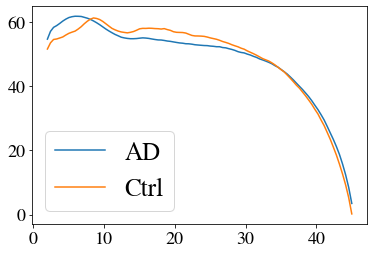

In [23]:
AD_PSD_dB = 20*np.log10(AD_PSD.PSDs)
ctrl_PSD_dB = 20*np.log10(ctrl_PSD.PSDs);
#AD_PSD_dB_std = (AD_PSD_dB - AD_PSD_dB.mean(axis=-1, keepdims=1))/AD_PSD_dB.std(axis=-1, keepdims=1)
#ctrl_PSD_dB_std = (ctrl_PSD_dB - ctrl_PSD_dB.mean(axis=-1, keepdims=1))/ctrl_PSD_dB.std(axis=-1, keepdims=1)
ADm = AD_PSD_dB.mean(axis=(1, 2))
ctrlm = ctrl_PSD_dB.mean(axis=(1, 2))
AD_PSD_dB_std = AD_PSD_dB[ADm >0]
ctrl_PSD_dB_std = ctrl_PSD_dB[ctrlm>0]
plt.plot(AD_PSD.freqs, AD_PSD_dB_std.mean(axis=(0, 1)), label="AD")
plt.plot(AD_PSD.freqs, ctrl_PSD_dB_std.mean(axis=(0, 1)), label="Ctrl")
plt.legend()

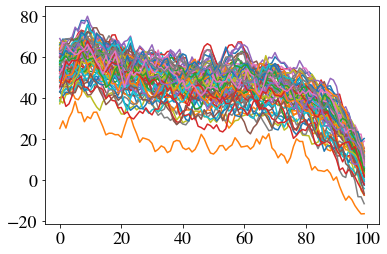

In [24]:
sub_ix = 0
for roi_ix in range(68):
    plt.plot(AD_PSD_dB[sub_ix, roi_ix])

In [110]:
pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv")

,RID,Gender,MEG_Age,MMSE,CDR,CDR_Box,Grp,idx,KeepIt,ncpts,ranks
0,R1146,female,59.1,20.0,1.0,5.5,AD,0,1,0,6
1,R1213,male,64.3,22.0,1.0,4.5,AD,1,1,0,6
2,R1224,female,53.9,23.0,1.0,6.0,AD,2,1,3,8
3,R1429,female,62.3,19.0,0.5,4.0,AD,3,1,2,6
4,R1456,male,53.1,24.0,0.5,4.0,AD,4,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...
175,UCSF294,female,63.0,NaN,NaN,NaN,Ctrl,175,1,3,3
176,UCSF302,female,62.0,NaN,NaN,NaN,Ctrl,176,1,6,4
177,UCSF310,male,47.0,NaN,NaN,NaN,Ctrl,177,1,7,4
178,UCSF403,male,62.0,NaN,NaN,NaN,Ctrl,178,1,2,4


## Another data

In [10]:
data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/"AD88_PSD_all.pkl");
ctrl_PSD = load_pkl(data_root/"Ctrl92_PSD_all.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_PSD_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_PSD_all.pkl


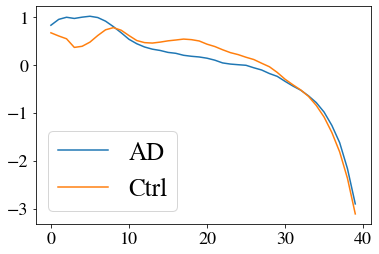

In [11]:
AD_PSD_dB = np.log10(AD_PSD)
ctrl_PSD_dB = np.log10(ctrl_PSD[:70]);
AD_PSD_dB_std = (AD_PSD_dB - AD_PSD_dB.mean(axis=-1, keepdims=1))/AD_PSD_dB.std(axis=-1, keepdims=1)
ctrl_PSD_dB_std = (ctrl_PSD_dB - ctrl_PSD_dB.mean(axis=-1, keepdims=1))/ctrl_PSD_dB.std(axis=-1, keepdims=1)
plt.plot(AD_PSD_dB_std.mean(axis=(0, 1)), label="AD")
plt.plot(ctrl_PSD_dB_std.mean(axis=(0, 1)), label="Ctrl")
plt.legend()

In [ ]:
for sub_ix in trange(92):
    f = plt.figure()
    for roi_ix in range(68):
        plt.plot(ctrl_PSD_dB[sub_ix, roi_ix])
    plt.savefig(MIDRES_ROOT/f"psd_figs/ctrl_{sub_ix}.jpg")
    f.clear()
    plt.close()

# From ts data

In [69]:
from utils.psd import butter_bandpass_filter
import scipy.signal as signal
def _get_psd_dB(ts, lfreq, hfreq, fs, nperseg=2048, is_smooth=True):
    """
    Calculate the power spectral density (PSD) of a given time series (ts) within a specified frequency range.

    Parameters:
    ts (array-like): Time series data
    lfreq (float): Lower frequency bound
    hfreq (float): Upper frequency bound
    fs (float): Sampling frequency
    nperseg (int, optional): Number of data points used in each segment for Welch's method. Default is 1200.

    Returns:
    freqs (array-like): Frequencies within the specified range
    psd_dB (array-like): Power spectral density in decibels
    """
    lpf = np.array([1, 2, 5, 2, 1]) 
    lpf = lpf/np.sum(lpf)
    
    # filter 
    #ts_filtered = butter_bandpass_filter(ts, lfreq, hfreq, fs=fs);
    sos = signal.butter(N=5, Wn=[lfreq, hfreq], fs=fs, btype="band", output="sos")
    ts_filtered = signal.sosfilt(sos, ts)
    
    # estimate 
    freqs, Sxx = signal.welch(ts_filtered, fs=fs, nperseg=nperseg, detrend=False);
    psd_raw = Sxx # !!! it seems no need to take square
    
    # to dB
    psd_dB = 10 * np.log10(psd_raw);
    
    
    # select my interested freq band
    idxs = np.bitwise_and(freqs>=lfreq, freqs<=hfreq);
    freqs = freqs[idxs]
    psd_dB = psd_dB[idxs];
    
    # convolve
    if is_smooth:
        psd_dB0 = np.convolve(psd_dB,lpf,'valid');
        psd_dB =  np.concatenate([psd_dB[:2], psd_dB0, psd_dB[-2:]])
    
    # dB to sq mag
    psd_raw = 10**(psd_dB/10)
    return freqs, psd_dB, psd_raw

In [70]:
data_root = DATA_ROOT/"AD_vs_Ctrl_ts/";
AD_ts = load_pkl(data_root/"AD88_all.pkl");
ctrl_ts = load_pkl(data_root/"Ctrl92_all.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_ts/AD88_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_ts/Ctrl92_all.pkl


In [71]:
np.linalg.svd(np.cov(ctrl_ts[:, :, 0].T))[1][:10]

array([5.60218462e+10, 1.32527519e+10, 8.59198999e+09, 7.20514982e+09,
       6.78101401e+09, 6.48328217e+09, 4.61843307e+09, 3.32436894e+09,
       2.75508768e+09, 2.29678542e+09])

In [72]:
def _run_fn(data, roi_ix, is_freq=False):
    ts = data[roi_ix]
    ts = signal.detrend(ts)
    freqs, _, dat = _get_psd_dB(ts, lfreq, hfreq, fs);
    if is_freq:
        return freqs
    else:
        return dat

In [73]:
lfreq, hfreq = 1, 40
fs = 600

freqs = _run_fn(AD_ts[0], 0, is_freq=True)
psds = []
for sub_ix in trange(88):
    psd = []
    data= AD_ts[sub_ix]
    with Parallel(n_jobs=10) as parallel:
        psd = parallel(delayed(_run_fn)(data, roi_ix) for roi_ix in range(0, 68))
    psds.append(psd)
psds = np.array(psds);

res = edict()
res.PSDs = psds
res.freqs = freqs
res.readme = """
    The PSD is not in dB, to dB, use 10*log(psd). 
    I get it in python with welch and convolve
    """
save_pkl(DATA_ROOT/f"AD_vs_Ctrl_PSD/AD88_PSD89_all_{lfreq}-{hfreq}.pkl", res, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:25<00:00,  3.50it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_PSD89_all_1-40.pkl


In [74]:
freqs = _run_fn(ctrl_ts[0], 0, is_freq=True)
psds = []
for sub_ix in trange(92):
    data= ctrl_ts[sub_ix]
    with Parallel(n_jobs=20) as parallel:
        psd = parallel(delayed(_run_fn)(data, roi_ix) for roi_ix in range(0, 68))
    psds.append(psd)
psds = np.array(psds);

res = edict()
res.PSDs = psds
res.freqs = freqs
res.readme = """
    The PSD is not in dB, to dB, use 10*log(psd). 
    I get it in python with welch and convolve
    """
save_pkl(DATA_ROOT/f"AD_vs_Ctrl_PSD/Ctrl92_PSD89_all_{lfreq}-{hfreq}.pkl", res, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:24<00:00,  3.83it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_PSD89_all_1-40.pkl


In [75]:
AD_PSD = load_pkl(DATA_ROOT/f"AD_vs_Ctrl_PSD/AD88_PSD89_all_{lfreq}-{hfreq}.pkl")
ctrl_PSD = load_pkl(DATA_ROOT/f"AD_vs_Ctrl_PSD/Ctrl92_PSD89_all_{lfreq}-{hfreq}.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_PSD89_all_1-40.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_PSD89_all_1-40.pkl


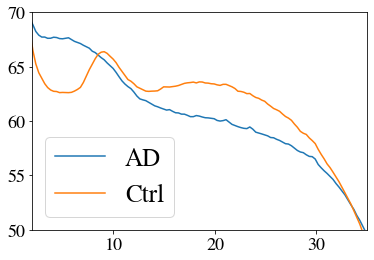

In [76]:
AD_PSD_dB = 20*np.log10(AD_PSD.PSDs)
ctrl_PSD_dB = 20*np.log10(ctrl_PSD.PSDs)[:];
AD_PSD_dB_std = (AD_PSD_dB-AD_PSD_dB.mean(axis=-1, keepdims=True))/AD_PSD_dB.std(axis=-1, keepdims=True)
ctrl_PSD_dB_std = (ctrl_PSD_dB-ctrl_PSD_dB.mean(axis=-1, keepdims=True))/ctrl_PSD_dB.std(axis=-1, keepdims=True)
AD_PSD_dB_std = AD_PSD_dB
ctrl_PSD_dB_std = ctrl_PSD_dB

ADm = AD_PSD_dB.mean(axis=(1, 2))
ctrlm = ctrl_PSD_dB.mean(axis=(1, 2))
AD_PSD_dB_std = AD_PSD_dB[ADm >0]
ctrl_PSD_dB_std = ctrl_PSD_dB[ctrlm>0]
plt.plot(AD_PSD.freqs, AD_PSD_dB_std.mean(axis=(0, 1)), label="AD")
plt.plot(AD_PSD.freqs, ctrl_PSD_dB_std.mean(axis=(0, 1)), label="Ctrl")
plt.ylim([50, 70])
plt.xlim([2, 35])
plt.legend()

# Get raw X and Y for sinica paper

Note I will std X across time/freq axis first, then std X across the sample size. 

Paper: Hypothesis Testing in Large-scale Functional Linear Regression

In [8]:
from scipy.io import savemat

# load data and preprocessing
OUTLIER_IDXS = dict(AD=[49], ctrl=[14, 19, 30, 38])
DATA = ["AD88_matlab_1-45.pkl", "Ctrl92_matlab_1-45.pkl"]
SAVE_PREFIX = "psd_matlab_1-45"


data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/DATA[0]);
ctrl_PSD = load_pkl(data_root/DATA[1]);
df0= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv");
df1= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt_more.csv");
df1 = df1.set_index("RID")
df0 = df0.set_index("RID");
df1 = df1.reindex(df0.index)
baseline = df1
baseline["Gender_binary"] = baseline["Gender"].apply(lambda x: 0 if x=="female" else 1);
baseline["Grp_binary"] = baseline["Grp"].apply(lambda x: 1 if x=="AD" else 0);


# The outlier idxs to rm
outlier_idxs = np.concatenate([OUTLIER_IDXS["AD"], len(AD_PSD.PSDs)+np.array(OUTLIER_IDXS["ctrl"])])
outlier_idxs = outlier_idxs.astype(int)

# make PSD in dB and std 
raw_X = np.concatenate([AD_PSD.PSDs, ctrl_PSD.PSDs]); #n x d x npts
X_dB = 10*np.log10(raw_X);
outlier_idxs2 = np.where(X_dB.mean(axis=(1, 2))<0)
#X = (X_dB - X_dB.mean(axis=-1, keepdims=1))/X_dB.std(axis=-1, keepdims=1);
X = X_dB

Y = np.array(baseline["MMSE"])[:X.shape[0]];
# if logi
#Yb = np.array(baseline["Grp_binary"])[:X.shape[0]];

sel_cov = ["Gender_binary", "MEG_Age","Education"]
Z_raw = np.array(baseline[sel_cov])[:X.shape[0]];

grp_idxs = np.array(baseline["Grp"])[:X.shape[0]];


outlier_idxs = np.sort(np.union1d(outlier_idxs, outlier_idxs2))


# remove outliers
X = np.delete(X, outlier_idxs, axis=0)
Y = np.delete(Y, outlier_idxs, axis=0)
Z_raw = np.delete(Z_raw, outlier_idxs, axis=0)
grp_idxs = np.delete(grp_idxs, outlier_idxs, axis=0)


#remove nan
keep_idx = ~np.bitwise_or(np.isnan(Y), np.isnan(Z_raw.sum(axis=1)));
X = X[keep_idx];
Y = Y[keep_idx]
Z_raw = Z_raw[keep_idx]
grp_idxs = grp_idxs[keep_idx]

Z = np.concatenate([np.ones((Z_raw.shape[0], 1)), Z_raw], axis=1); # add intercept


freqs = AD_PSD.freqs;
# only take PSD between [2, 35] freqs of interest
X = X[:, :, np.bitwise_and(freqs>=2, freqs<=35)]
X = X/X.mean();


if SAVE_PREFIX.endswith("X1err"):
    print("add noise to PSD")
    X = X+np.random.randn(*X.shape)*0.1;



Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_matlab_1-45.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_matlab_1-45.pkl


In [9]:
# remove effect of covs by projection, 
# refer to HDF (on Mar 11, 2024)
pZ = Z[:, 2:]
stdpZ = (pZ - pZ.mean(axis=0))/pZ.std(axis=0)
Z[:, 2:] = stdpZ;
Z = Z[:, 1:];
Proj = np.eye(Z.shape[0]) - Z @ np.linalg.inv(Z.T @ Z) @ Z.T;

Y = Y - Y.mean(axis=0, keepdims=1)
X = X - X.mean(axis=0, keepdims=1)

pY = Proj @ Y;
pX = Proj[None] @ X.transpose(1, 0, 2);
pX = pX.transpose(1, 0, 2);

savemat(MIDRES_ROOT/f"matlab_real_data/{SAVE_PREFIX}.mat", 
           {
               'X_centered': pX, 
               'Y_centered': pY
           }
       )

# Get thetas for sinica paper

Paper: Hypothesis Testing in Large-scale Functional Linear Regression

In [6]:
from splines import obt_bsp_basis_Rfn_wrapper
from scipy.io import savemat
def gram_schmidt(vectors):
    vectors = vectors.T
    basis = []
    for v in vectors:
        for b in basis:
            v = v - (np.dot(v, b) / np.dot(b, b)) * b 
        if np.linalg.norm(v) > 1e-10:  
            basis.append(v / np.linalg.norm(v))  
    return np.array(basis).T

In [34]:
# load data and preprocessing
OUTLIER_IDXS = dict(AD=[], ctrl=[])
#OUTLIER_IDXS = dict(AD=[49], ctrl=[14, 19, 30, 38])
DATA = ["AD88_PSD89_all.pkl", "Ctrl92_PSD89_all.pkl"]
SAVE_PREFIX = "psd89"

data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/DATA[0]);
ctrl_PSD = load_pkl(data_root/DATA[1]);
if not isinstance(AD_PSD, dict):
    tmp1 = AD_PSD
    tmp2 = ctrl_PSD
    AD_PSD = edict()
    AD_PSD.PSDs = tmp1
    AD_PSD.freqs = np.arange(1, 41)
    ctrl_PSD = edict()
    ctrl_PSD.PSDs = tmp2
    ctrl_PSD.freqs = np.arange(1, 41)
baseline = pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv");
baseline["Gender_binary"] = baseline["Gender"].apply(lambda x: 0 if x=="female" else 1);
baseline["Grp_binary"] = baseline["Grp"].apply(lambda x: 1 if x=="AD" else 0);

# The outlier idxs to rm
outlier_idxs = np.concatenate([OUTLIER_IDXS["AD"], len(AD_PSD.PSDs)+np.array(OUTLIER_IDXS["ctrl"])])
outlier_idxs = outlier_idxs.astype(int)

# make PSD in dB and std 
raw_X = np.concatenate([AD_PSD.PSDs, ctrl_PSD.PSDs]); #n x d x npts
X_dB = 10*np.log10(raw_X);
#X = (X_dB - X_dB.mean(axis=-1, keepdims=1))/X_dB.std(axis=-1, keepdims=1);
X = X_dB # do not std across freq aixs, otherwise, it causes low-rank mat in the subseq step

Y = np.array(baseline["MMSE"])[:X.shape[0]];


# remove outliers
X = np.delete(X, outlier_idxs, axis=0)
Y = np.delete(Y, outlier_idxs, axis=0)


#remove nan
keep_idx = ~np.isnan(Y)
X = X[keep_idx];
Y = Y[keep_idx]


X_centered = X - X.mean(axis=0, keepdims=1);
Y_centered = Y - Y.mean(axis=0, keepdims=1);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../data/AD_vs_Ctrl_PSD/AD88_PSD89_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_PSD89_all.pkl


In [35]:
sn = 12 # sn is the N in our paper
for sn in [6, 8, 10, 12, 14]:
    order = 4 # bspline order, cubic
    npts = X_centered.shape[-1]
    x = np.linspace(0, 1, npts)
    basis_mat = obt_bsp_basis_Rfn_wrapper(x, sn, order);
    basis_orth = gram_schmidt(basis_mat);
    solve_part = np.linalg.inv(basis_orth.T @ basis_orth) @ basis_orth.T;
    thetas = np.array([tX @ solve_part.T for tX in X_centered]).transpose(1, 0, 2);
    
    # save it 
    savemat(MIDRES_ROOT/f"matlab_real_data/{SAVE_PREFIX}_{sn}.mat", {'thetas': [theta for theta in thetas], 
                                                    'Y_centered':Y_centered})

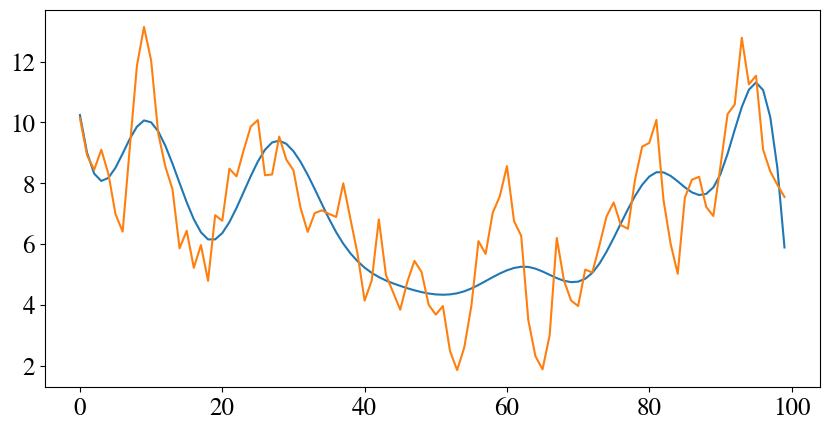

In [30]:
# check it 
sub_ix = 10
roi_ix = 1
theta = thetas[roi_ix, sub_ix]
recon_psd = basis_orth @ theta
true_psd = X_centered[sub_ix, roi_ix];
plt.plot(recon_psd)
plt.plot(true_psd)